In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import scipy.stats as stats
from sklearn.metrics import brier_score_loss, roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler

In [85]:
def get_return_dataframe(path,start_date,end_date,maturity_target = 6,ifreturn = False):
    #（1）Import the required data and compute the true return
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    
    df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    # Ensure the data is sorted by date
    df_filtered = df_filtered.sort_values('Date')
    
    # Calculate the 6-month return. The shift will be based on trading days (~126 trading days in 6 months)
    days = maturity_target * 21
    if ifreturn == False:
        df_filtered['6m_return'] = df_filtered['Adj Close'].pct_change(periods = days).shift(-days)
    else:
        df_filtered['6m_return'] = df_filtered['Adj Close']
    
    df_return = df_filtered[['Date','6m_return']].dropna()
    df_return['log_6m_return'] = np.log(1+df_return['6m_return'])
    
    return df_return

In [86]:
# create a function to calculate the accuracy of the predictions
def calculate_prediction_accuracy(df, actual_col, p10_col, p50_col, p90_col):
    # Count how many times the actual log return falls within the p10 and p90 interval
    within_interval = df.apply(lambda row: row[p10_col] <= row[actual_col] <= row[p90_col], axis=1).sum()
    # Count how many times the actual log return is greater than the median prediction
    above_median = (df[actual_col] > df[p50_col]).sum()
    # Calculate the total number of points
    total_points = df.shape[0]
    
    # Calculate the accuracy percentages
    interval_accuracy = within_interval / total_points
    median_accuracy = above_median / total_points
    
    return {
        'within_interval_accuracy': interval_accuracy,
        'above_median_accuracy': median_accuracy,
        'total_points': total_points
    }


In [82]:
# Function to calculate z-score adjusted for skewness and kurtosis using Cornish-Fisher expansion
def z_score_cf_expansion(q, skew, kurt):
    # z is the z-score for the standard normal distribution
    z = stats.norm.ppf(q)
    
    # Cornish-Fisher expansion
    z_adj = z + (z**2 - 1) * skew / 6 + (z**3 - 3 * z) * (kurt - 3) / 24 - (2 * z**3 - 5 * z) * (skew**2) / 36
    return z_adj

In [83]:
def results_calculation(path,market,large_change_threshold,start_date,end_date,maturity_target = 6,ifreturn = False):
    '''
    path: True data file path
    market: The str of the selected market. e.g. 'sp6m','bac'
    large_change_threshold: Value indicated in the mpd_stats
    start_date: Time used to start calculations
    end_date: Time used to the end of the calculation
    ifreturn: whether the given data is return or price
    '''
    #（2）Take the market to be calculated, as the methodology document says it's all been collated into a forecast for 6 months out
    selected_market = mpd_stats_weekly[mpd_stats_weekly['market'] == market]
    market_return = get_return_dataframe(path,start_date,end_date,maturity_target,ifreturn)

         
    
    #（3）Comparing true return and predicted mean values
    # Based on the date in selected_market, take out the corresponding true return
    merged_data = pd.merge(selected_market,market_return,on = 'Date',how = 'left')
    merged_data.dropna()
    plt.figure(figsize=(14, 7))
    plt.plot(merged_data['Date'], merged_data['mu'], label=f'mu_{market}6m', color='blue')
    plt.plot(merged_data['Date'], merged_data['p50'], label=f'p50_{market}6m', color='orange')
    plt.plot(merged_data['Date'], merged_data['6m_return'], label='6m_change', color='green')

    plt.title(f'{market} Predicted vs Actual Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
    
    
    #（4）Comparison of gaps by confidence intervals
    # Apply the 'calculate_prediction_accuracy' function to our merged data
    # Assuming the actual log returns column in merged_data is 'log_6m_return'
    accuracy_results_selected = calculate_prediction_accuracy(
        merged_data, 
        actual_col='log_6m_return', 
        p10_col='p10', 
        p50_col='p50', 
        p90_col='p90'
    )
    print(f'the accuracy of {market} predictions',accuracy_results_selected)
    
    
    #（5）Check whether can predict accuracy by directionality
    # Convert the 'log_6m_return' column to +1 if positive, -1 if negative
    market_return['log_6m_return_sign'] = market_return['log_6m_return'].apply(lambda x: 1 if x > 0 else -1)
    # print(market_return)
    
    # Calculate the z-score for the 50th percentile (median)
    q_median = 0.5
    merged_data['z_median'] = z_score_cf_expansion(q_median, merged_data['skew'], merged_data['kurt'])

    # Calculate the adjusted probability of a positive return using the adjusted z-score for the 50th percentile
    merged_data['adj_prob_positive_return'] = 1 - stats.norm.cdf(merged_data['z_median'])

    # Display the new DataFrame with the calculated adjusted probabilities
    merged_data[['Date', 'mu', 'sd', 'skew', 'kurt', 'adj_prob_positive_return']]
    
    # Convert actual sign of return to binary (1 for positive, 0 for non-positive)
    market_return['actual_binary_outcome'] = market_return['log_6m_return_sign'].apply(lambda x: 1 if x == 1 else 0)
    
    # Merge the actual outcomes with the predicted probabilities
    eval_data = pd.merge(merged_data, market_return, on='Date')
    
    # Calculate Brier score
    brier_score = brier_score_loss(eval_data['actual_binary_outcome'], eval_data['adj_prob_positive_return'])
    # print(eval_data['actual_binary_outcome'])
    # print(eval_data['adj_prob_positive_return'])

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(eval_data['actual_binary_outcome'], eval_data['adj_prob_positive_return'])
    roc_auc = auc(fpr, tpr)

    # Calculate Log Loss
    logloss = log_loss(eval_data['actual_binary_outcome'], eval_data['adj_prob_positive_return'])
    
    # Print the evaluation metrics
    print("\nUp and down accuracy")
    print(pd.DataFrame([brier_score, roc_auc, logloss], index = ["brier", "roc_auc", "logloss"], columns = ["score"]))
    
    
    #（6）Judging the accuracy of predictions of large rises and falls
    market_return['large_increase'] = market_return['log_6m_return'].apply(lambda x: 1 if x >= large_change_threshold else 0)
    market_return['large_decrease'] = market_return['log_6m_return'].apply(lambda x: 1 if x <= -large_change_threshold else 0)
    
    # Using the large change threshold indicated by the mpd data (different market have different value)
    # 6m increase prediction scores
    eval_data = pd.merge(merged_data, market_return, on='Date')
    # Calculate Brier score
    brier_score_in = brier_score_loss(eval_data['large_increase'], eval_data['prInc'])

    # Calculate ROC curve and AUC
    fpr_in, tpr_in, thresholds_in = roc_curve(eval_data['large_increase'], eval_data['prInc'])
    roc_auc_in = auc(fpr_in, tpr_in)

    # Calculate Log Loss
    logloss_in = log_loss(eval_data['large_increase'], eval_data['prInc'])

    # Print the evaluation metrics of increase
    print("\nLarge increase accuracy")
    print(pd.DataFrame([brier_score_in, roc_auc_in, logloss_in], index = ["brier", "roc_auc", "logloss"], columns = ["score"]))
    
    # 6m decrease prediction scores
    # Calculate Brier score
    brier_score_de = brier_score_loss(eval_data['large_decrease'], eval_data['prDec'])

    # Calculate ROC curve and AUC
    fpr_de, tpr_de, thresholds_de = roc_curve(eval_data['large_decrease'], eval_data['prDec'])
    roc_auc_de = auc(fpr_de, tpr_de)

    # Calculate Log Loss
    logloss_de = log_loss(eval_data['large_decrease'], eval_data['prDec'])

    # Print the evaluation metrics
    print("\nLarge loss accuracy")
    print(pd.DataFrame([brier_score_de, roc_auc_de, logloss_de], index = ["brier", "roc_auc", "logloss"], columns = ["score"]))

In [ ]:
mpd_stats_weekly = pd.read_csv('mpd_stats_cleaned.csv')

In [ ]:
mpd_stats_weekly['Date'] = pd.to_datetime(mpd_stats_weekly['Date'])

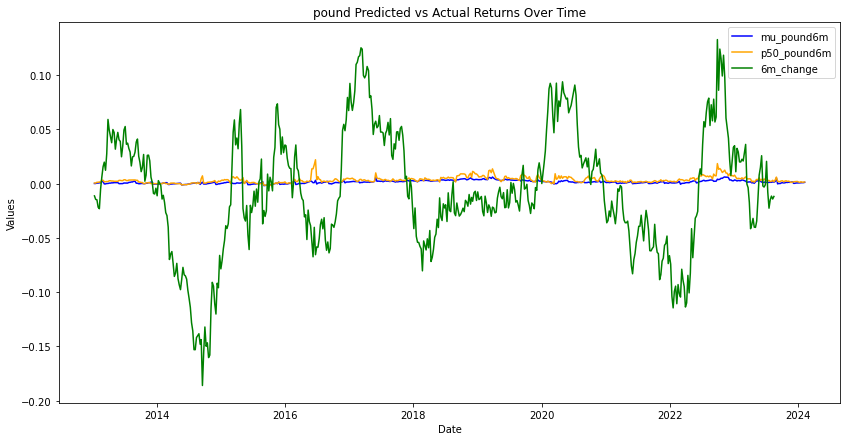

the accuracy of pound predictions {'within_interval_accuracy': 0.671280276816609, 'above_median_accuracy': 0.3892733564013841, 'total_points': 578}

Up and down accuracy
            score
brier    0.249166
roc_auc  0.415820
logloss  0.691480

Large increase accuracy
            score
brier    0.018627
roc_auc  0.789027
logloss  0.085070

Large loss accuracy
            score
brier    0.060148
roc_auc  0.170112
logloss  0.404819


In [90]:
results_calculation(path = 'EURUSD=X.csv',market='pound',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target = 6)

In [ ]:
results_calculation(path = 'GBPUSD=X.csv',market='euro',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target = 6)

In [ ]:
results_calculation(path = 'JPYUSD=X.csv',market='yen',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target = 6)

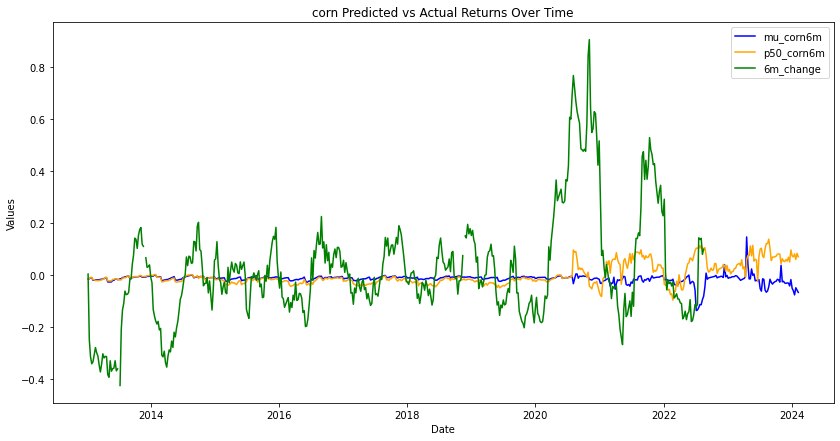

the accuracy of corn predictions {'within_interval_accuracy': 0.6505190311418685, 'above_median_accuracy': 0.4532871972318339, 'total_points': 578}

Up and down accuracy
            score
brier    0.257669
roc_auc  0.421178
logloss  0.708575

Large increase accuracy
            score
brier    0.207038
roc_auc  0.342206
logloss  0.678945

Large loss accuracy
            score
brier    0.195514
roc_auc  0.689847
logloss  0.602371


In [71]:
results_calculation(path = 'corn.csv',market='corn',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target = 6)

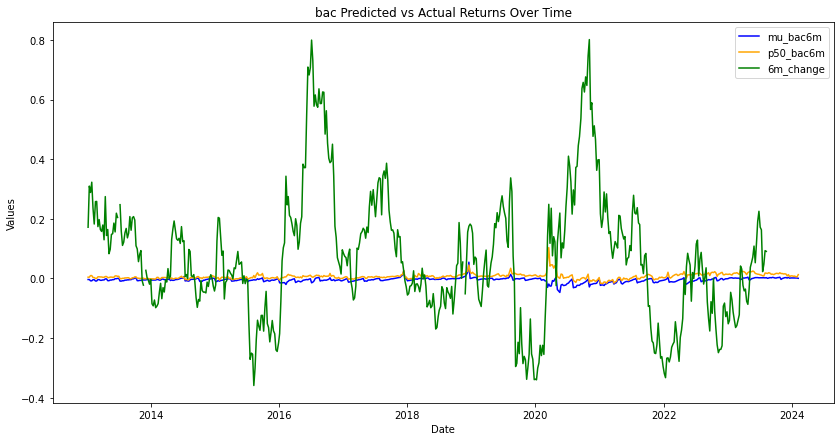

the accuracy of bac predictions {'within_interval_accuracy': 0.5795847750865052, 'above_median_accuracy': 0.5657439446366782, 'total_points': 578}

Up and down accuracy
            score
brier    0.257529
roc_auc  0.567644
logloss  0.708243

Large increase accuracy
            score
brier    0.348744
roc_auc  0.668284
logloss  1.168319

Large loss accuracy
            score
brier    0.173092
roc_auc  0.483449
logloss  0.580388


In [72]:
results_calculation(path = 'BAC.csv',market='bac',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target =6)

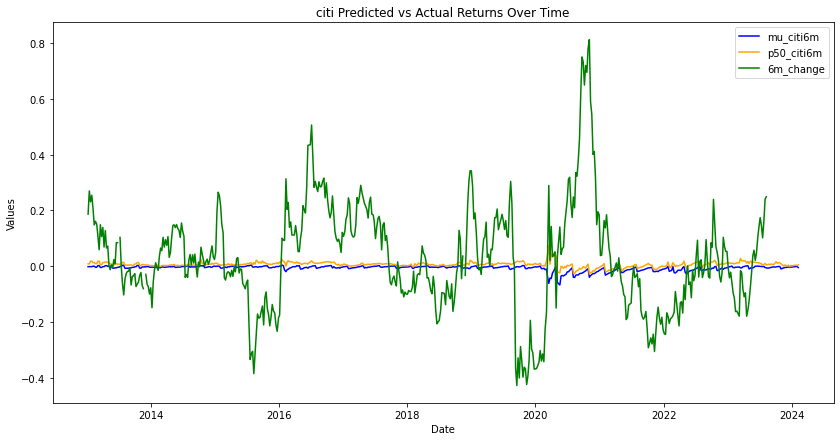

the accuracy of citi predictions {'within_interval_accuracy': 0.610726643598616, 'above_median_accuracy': 0.486159169550173, 'total_points': 578}

Up and down accuracy
            score
brier    0.254673
roc_auc  0.479579
logloss  0.702523

Large increase accuracy
            score
brier    0.276975
roc_auc  0.576276
logloss  0.997068

Large loss accuracy
            score
brier    0.202513
roc_auc  0.493522
logloss  0.673165


In [73]:
results_calculation(path = 'C.csv',market='citi',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target =6)

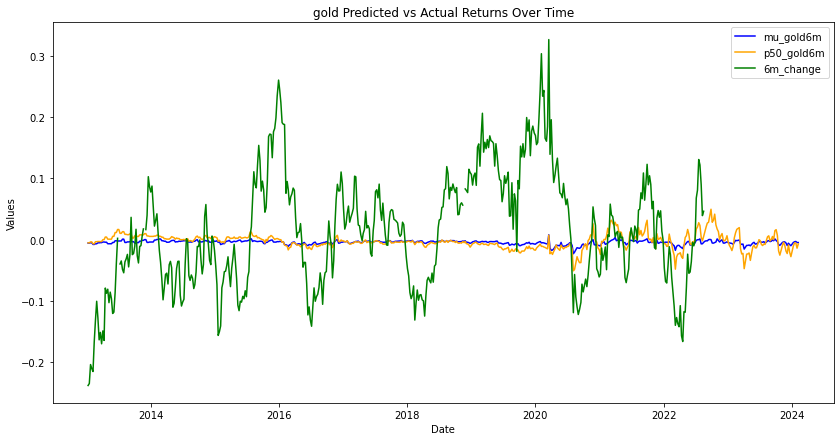

the accuracy of gold predictions {'within_interval_accuracy': 0.7231833910034602, 'above_median_accuracy': 0.44982698961937717, 'total_points': 578}

Up and down accuracy
            score
brier    0.250278
roc_auc  0.542296
logloss  0.693765

Large increase accuracy
            score
brier    0.146875
roc_auc  0.354243
logloss  0.619649

Large loss accuracy
            score
brier    0.113970
roc_auc  0.528960
logloss  0.431873


In [74]:
results_calculation(path = 'gold.csv',market='gold',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target =6)

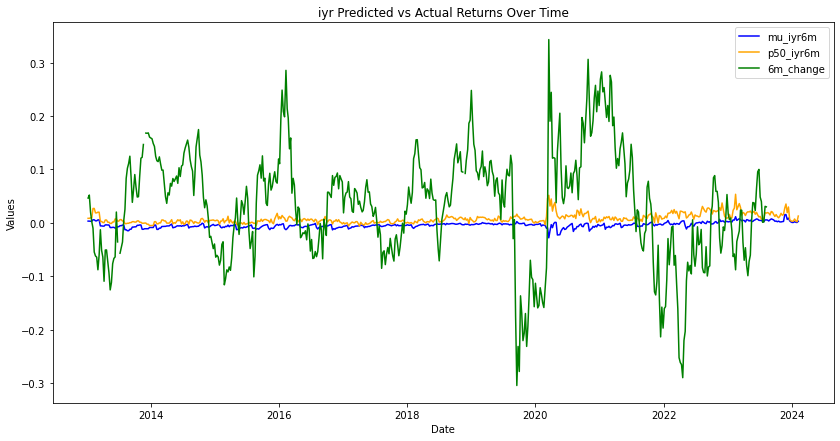

the accuracy of iyr predictions {'within_interval_accuracy': 0.6187175043327556, 'above_median_accuracy': 0.587521663778163, 'total_points': 577}

Up and down accuracy
            score
brier    0.267389
roc_auc  0.623815
logloss  0.728063

Large increase accuracy
            score
brier    0.178539
roc_auc  0.627768
logloss  0.594293

Large loss accuracy
            score
brier    0.091355
roc_auc  0.435198
logloss  0.335143


In [75]:
results_calculation(path = 'iyr.csv',market='iyr',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target =6)

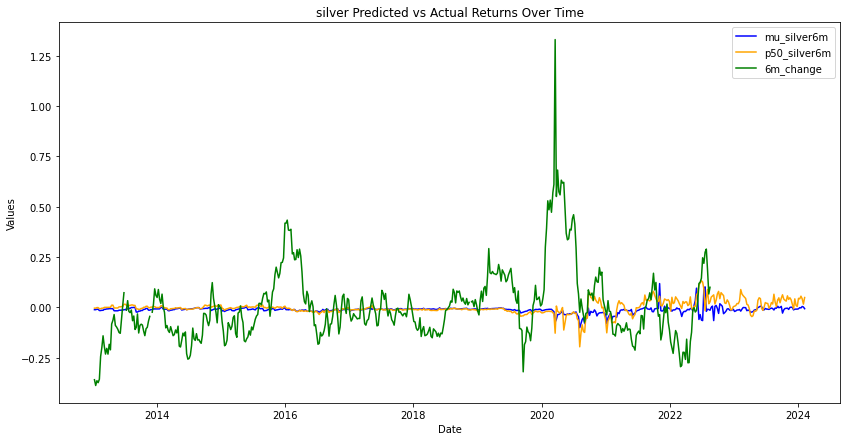

the accuracy of silver predictions {'within_interval_accuracy': 0.7182608695652174, 'above_median_accuracy': 0.38782608695652177, 'total_points': 575}

Up and down accuracy
            score
brier    0.250967
roc_auc  0.525806
logloss  0.695151

Large increase accuracy
            score
brier    0.149977
roc_auc  0.537264
logloss  0.501712

Large loss accuracy
            score
brier    0.243945
roc_auc  0.521899
logloss  0.729898


In [76]:
results_calculation(path = 'silver.csv',market='silver',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target =6)

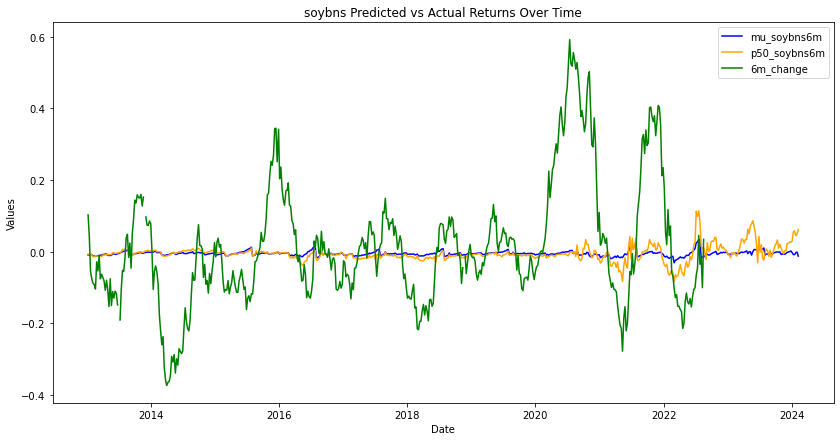

the accuracy of soybns predictions {'within_interval_accuracy': 0.6505190311418685, 'above_median_accuracy': 0.41522491349480967, 'total_points': 578}

Up and down accuracy
            score
brier    0.255720
roc_auc  0.459730
logloss  0.704691

Large increase accuracy
            score
brier    0.179668
roc_auc  0.297018
logloss  0.654505

Large loss accuracy
            score
brier    0.212418
roc_auc  0.676418
logloss  0.682160


In [77]:
results_calculation(path = 'soybean.csv',market='soybns',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target =6)

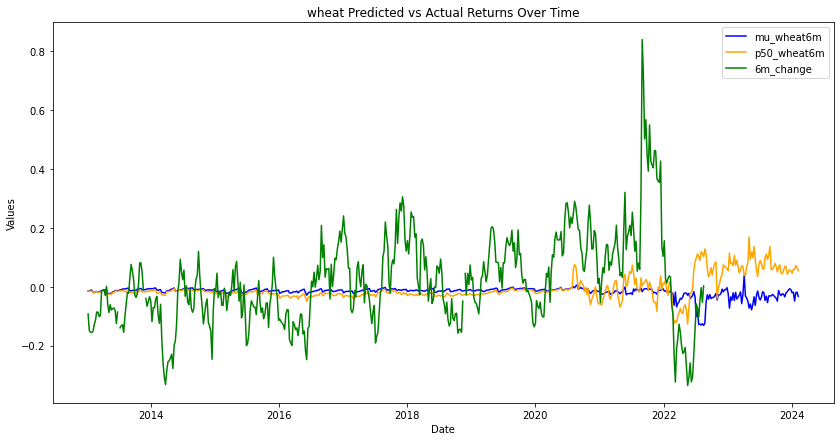

the accuracy of wheat predictions {'within_interval_accuracy': 0.7560553633217993, 'above_median_accuracy': 0.47750865051903113, 'total_points': 578}

Up and down accuracy
            score
brier    0.254371
roc_auc  0.455299
logloss  0.701931

Large increase accuracy
            score
brier    0.209260
roc_auc  0.377649
logloss  0.667894

Large loss accuracy
            score
brier    0.155494
roc_auc  0.686633
logloss  0.484710


In [78]:
results_calculation(path = 'wheat.csv',market='wheat',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target =6)

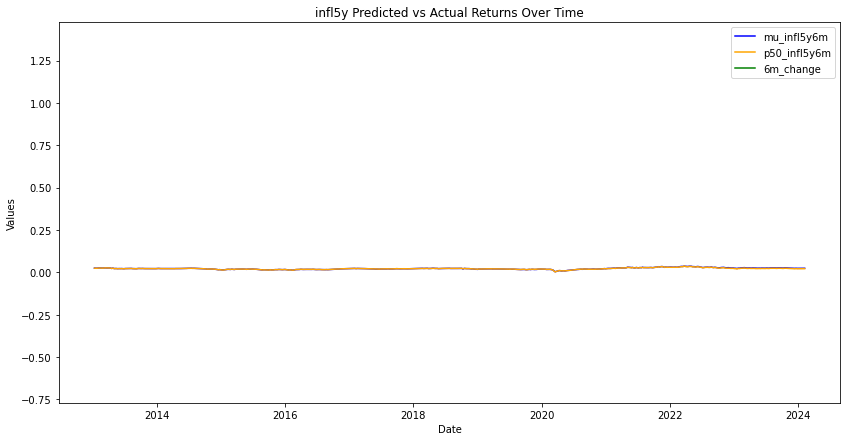

the accuracy of infl5y predictions {'within_interval_accuracy': 0.0035026269702276708, 'above_median_accuracy': 0.02276707530647986, 'total_points': 571}

Up and down accuracy
            score
brier    0.248054
roc_auc  0.187500
logloss  0.689281

Large increase accuracy
            score
brier    0.327320
roc_auc  0.750000
logloss  0.906027

Large loss accuracy
            score
brier    0.114947
roc_auc  0.791667
logloss  0.370845


In [87]:
results_calculation(path = 'CPALTT01USM657N.csv',market='infl5y',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target =6,ifreturn = True)

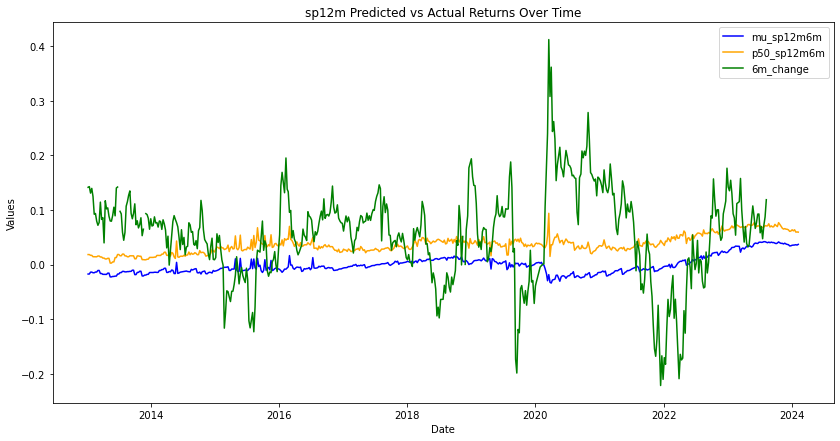

the accuracy of sp12m predictions {'within_interval_accuracy': 0.9463667820069204, 'above_median_accuracy': 0.6020761245674741, 'total_points': 578}

Up and down accuracy
            score
brier    0.304666
roc_auc  0.715966
logloss  0.803657

Large increase accuracy
            score
brier    0.179621
roc_auc  0.746421
logloss  0.567189

Large loss accuracy
            score
brier    0.057169
roc_auc  0.640476
logloss  0.239430


In [88]:
results_calculation(path = '^SPX.csv',market='sp12m',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target =6)

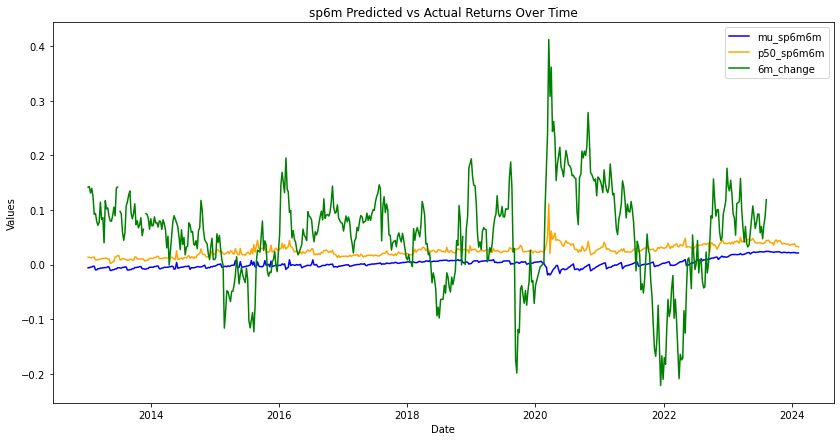

the accuracy of sp6m predictions {'within_interval_accuracy': 0.8633217993079585, 'above_median_accuracy': 0.6608996539792388, 'total_points': 578}

Up and down accuracy
            score
brier    0.303073
roc_auc  0.697732
logloss  0.800399

Large increase accuracy
            score
brier    0.201640
roc_auc  0.779776
logloss  0.821004

Large loss accuracy
            score
brier    0.052033
roc_auc  0.665058
logloss  0.209593


In [89]:
results_calculation(path = '^SPX.csv',market='sp6m',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14',maturity_target =6)